In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm
from random import seed, randint, choice

from swarm_sim import *

%matplotlib inline 

In [2]:
PATH = '..\data\Traces_Nanosatellites\\track_'
satellites = {}

with tqdm(total=100, desc='Extracting data') as pbar:
    for i in range(0,100):
        df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)
    
DURATION = satellites[0].columns.tolist()

satellites[0].head()

Extracting data: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [3]:
CONNECTION_RANGE = 30000
CHUNKS = 1800     # Number of timestamps to analyse
NB_NODES = 100

swarm_topo = {}

with tqdm(total=CHUNKS, desc='Converting to Swarm') as pbar:
    for t in range(CHUNKS):
        swarm_topo[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
        )
        pbar.update(1)

print(swarm_topo[0])

with tqdm(total=len(swarm_topo.keys()), desc='Neighbor matrix') as pbar:
    for t in swarm_topo.keys():
        neighbor_matrix = swarm_topo[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix:   1%|▏         | 24/1800 [00:00<00:15, 117.85it/s]

Swarm of 100 node(s), connection range: 30000


Neighbor matrix: 100%|██████████| 1800/1800 [00:15<00:00, 114.06it/s]


In [5]:
# Reference temporal evolution: Average Degree, Average Clustering Coefficient
ref_ad, ref_acc = [], []

for t,swarm in swarm_topo.items():
    ref_ad.append(np.mean(swarm.degree()))
    ref_acc.append(np.mean(swarm.cluster_coef()))
    
# Run only once
"""
diameters = []
with tqdm(total=len(swarm_topo.keys()), desc='Diameter') as pbar:
    for swarm in swarm_topo.values():
        diameters.append(swarm.diameter(swarm)[2]-1)
        pbar.update(1)
ref_dia = np.mean(diameters)
"""

"\ndiameters = []\nwith tqdm(total=len(swarm_topo.keys()), desc='Diameter') as pbar:\n    for swarm in swarm_topo.values():\n        diameters.append(swarm.diameter(swarm)[2]-1)\n        pbar.update(1)\nref_dia = np.mean(diameters)\n"

In [9]:
print('Maximum AD:', np.max(ref_ad), '\tTimestamp:', ref_ad.index(np.max(ref_ad)))
print('Maximum ACC:', np.max(ref_acc), '\tTimestamp:', ref_acc.index(np.max(ref_acc)))

print('\nMinimum AD:', np.min(ref_ad), '\tTimestamp:', ref_ad.index(np.min(ref_ad)))
print('Minimum ACC:', np.min(ref_acc), '\tTimestamp:', ref_acc.index(np.min(ref_acc)))


Maximum AD: 10.88 	Timestamp: 1505
Maximum ACC: 0.5879346991681088 	Timestamp: 219

Minimum AD: 5.3 	Timestamp: 816
Minimum ACC: 0.39613720593132357 	Timestamp: 1043


In [28]:
def colormap(swarm, val, title=None):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    
    cm = plt.cm.get_cmap('RdYlBu_r')
    sc = ax.scatter(x_data, y_data, z_data, c=val, s=35, edgecolors='black', cmap=cm)
    plt.colorbar(sc)
    ax.set_title(title)

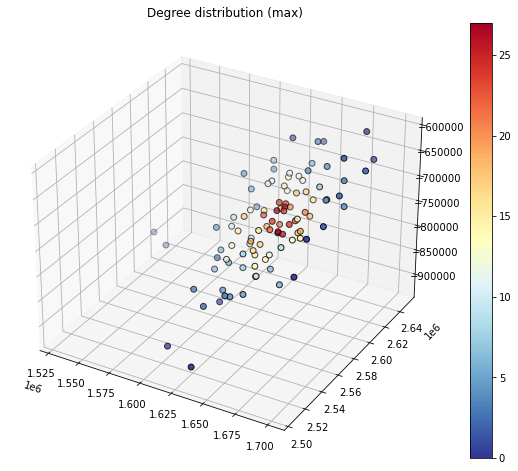

In [29]:
swarm = swarm_topo[1505]
colormap(swarm, val=swarm.degree(), title='Degree distribution (max)')

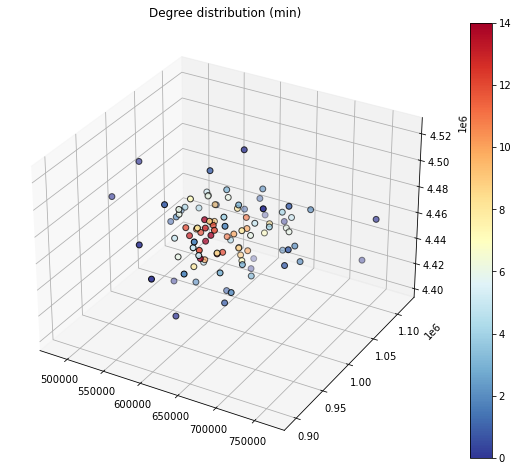

In [30]:
swarm = swarm_topo[816]
colormap(swarm, val=swarm.degree(), title='Degree distribution (min)')

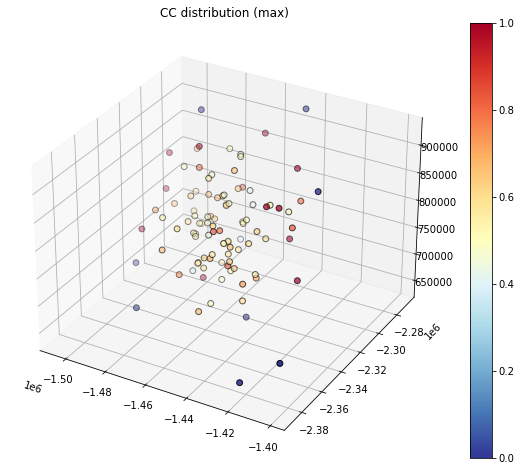

In [31]:
swarm = swarm_topo[219]
colormap(swarm, val=swarm.cluster_coef(), title='CC distribution (max)')

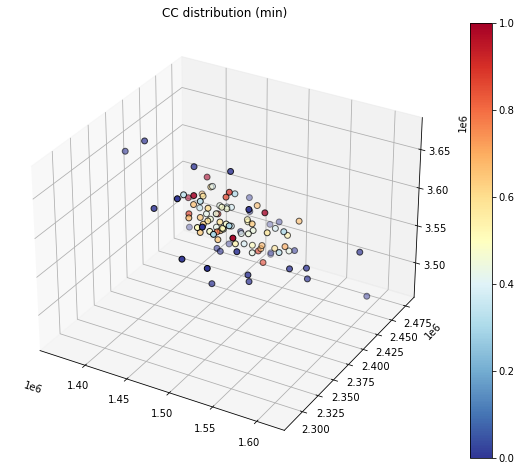

In [32]:
swarm = swarm_topo[1043]
colormap(swarm, val=swarm.cluster_coef(), title='CC distribution (min)')

In [69]:
# Apply MDRW
group_ids = range(10)

swarm = swarm_topo[1505]
swarm.reset_groups()
mdrw_swarms = swarm.MDRW(n=len(group_ids), s=1)

In [70]:
print(mdrw_swarms[0])
for n in mdrw_swarms[0].nodes:
    print(n)

Swarm of 10 node(s), connection range: 30000
Node ID 72 (1689029.39743418,2594586.05455231,-664575.045123253) has 2 neighbor(s)	Group: 0
Node ID 19 (1633125.336561,2594159.43705736,-762796.089454238) has 19 neighbor(s)	Group: 0
Node ID 90 (1629335.64676355,2596030.77021675,-745535.030790579) has 23 neighbor(s)	Group: 0
Node ID 80 (1620222.08687468,2586338.3813488,-740625.9416334209) has 17 neighbor(s)	Group: 0
Node ID 71 (1615443.06128127,2600780.58347649,-752050.14194206) has 12 neighbor(s)	Group: 0
Node ID 78 (1623957.93996614,2604572.78412325,-752683.726804904) has 15 neighbor(s)	Group: 0
Node ID 23 (1611098.05076722,2615150.3362328,-769251.9746526559) has 4 neighbor(s)	Group: 0
Node ID 13 (1608171.61603461,2591677.7236303,-758565.896922427) has 9 neighbor(s)	Group: 0
Node ID 34 (1692914.81161377,2631007.11825018,-642015.619405381) has 1 neighbor(s)	Group: 0
Node ID 93 (1700251.7863678,2608209.45529288,-627912.0215829429) has 2 neighbor(s)	Group: 0


In [85]:
def top_n_sources(swarm, n=10):
    p = {} #proba of each node to become a source
    degrees = swarm.degree()
    for node in swarm.nodes:
        ndeg = degrees[node.id]
        p[node.id] = 0.
        if ndeg > 0:
            p[node.id] = 1./ndeg
    return dict(sorted(p.items(), key=lambda x:x[1], reverse=True)[:n])
    

In [87]:
swarm = swarm_topo[1505]
top10 = top_n_sources(swarm, n=10)
src_ids = list(top10.keys())

In [89]:
def param_MDRW(swarm, src_ids, s=1, overlap=False):
    sources = [swarm.get_node_by_id(id) for id in src_ids]
    swarms = {} # Dict(group ID:Swarm)
    for i,src in enumerate(sources): # Initialize swarms
        src.set_group(i)
        swarms[i] = Swarm(swarm.connection_range, nodes=[src])
    free_nodes = [n for n in swarm.nodes if n.group==-1]
    while free_nodes: # Spread paths to desired length
        for k in swarms.keys():
            n_i = swarms[k].nodes[-1] # Current node
            free_neighbors = set(free_nodes).intersection(n_i.neighbors)
            if free_neighbors: # At least one unassigned neighbor
                n_j = n_i.random_walk(i, overlap) # Next node
            else:
                n_j = swarm.random_jump(s, overlap) # If no neighbor, perform random jump in the graph
            n_j.set_group(n_i.group)
            swarms[k].add_node(n_j) 
            free_nodes.remove(n_j)
    return swarms

In [147]:
def plot_groups(swarms, title=None, show_edges=True):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    colordict = {
        0:'tab:blue',
        1:'tab:orange',
        2:'tab:green',
        3:'tab:red',
        4:'tab:purple',
        5:'tab:brown',
        6:'tab:pink',
        7:'tab:gray',
        8:'tab:olive',
        9:'tab:cyan',
        -1:'w'
    }
    
    for gid, swarm in swarms.items():
        x_data = [node.x for node in swarm.nodes]
        y_data = [node.y for node in swarm.nodes]
        z_data = [node.z for node in swarm.nodes]
        sc = ax.scatter(x_data, y_data, z_data, 
                        c=colordict[gid], 
                        s=45, 
                        edgecolors='black',
                        label=str(gid))
        if show_edges:
            for node in swarm.nodes:
                for n in node.neighbors:
                    if n.group==gid:
                        ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], 
                                c=colordict[gid]
                                )
    
    ax.legend(title='Groups')
    
    ax.set_title(title)

In [149]:
swarm = swarm_topo[0]
top10 = top_n_sources(swarm, n=10)
src_ids = list(top10.keys())

swarm.reset_groups()
param_mdrw_swarms = param_MDRW(swarm, src_ids, s=1)

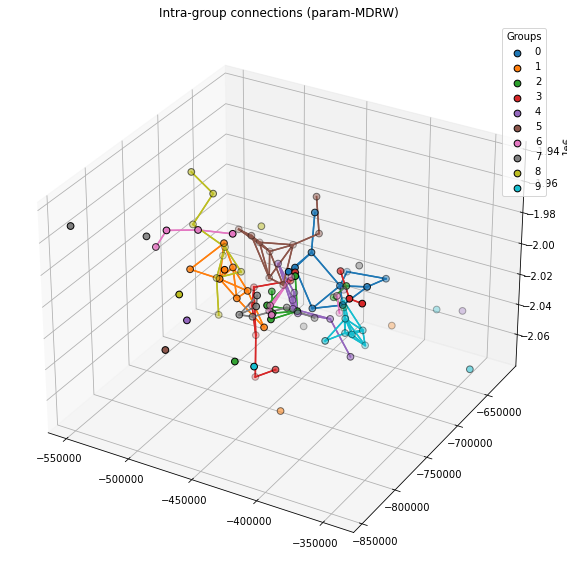

In [150]:
plot_groups(param_mdrw_swarms, title='Intra-group connections (param-MDRW)')

In [144]:
for gid, sw in param_mdrw_swarms.items():
    isl = 0
    for node in sw.nodes:
            for n in node.neighbors:
                if n.group==node.group:
                    isl+=1
    print('Number of ISLs in group', gid,':', int(isl/2))

Number of ISLs in group 0 : 14
Number of ISLs in group 1 : 13
Number of ISLs in group 2 : 11
Number of ISLs in group 3 : 9
Number of ISLs in group 4 : 12
Number of ISLs in group 5 : 17
Number of ISLs in group 6 : 7
Number of ISLs in group 7 : 6
Number of ISLs in group 8 : 8
Number of ISLs in group 9 : 16


In [151]:
swarm.reset_groups()
mdrw_swarms = swarm.MDRW(n=10, s=1)

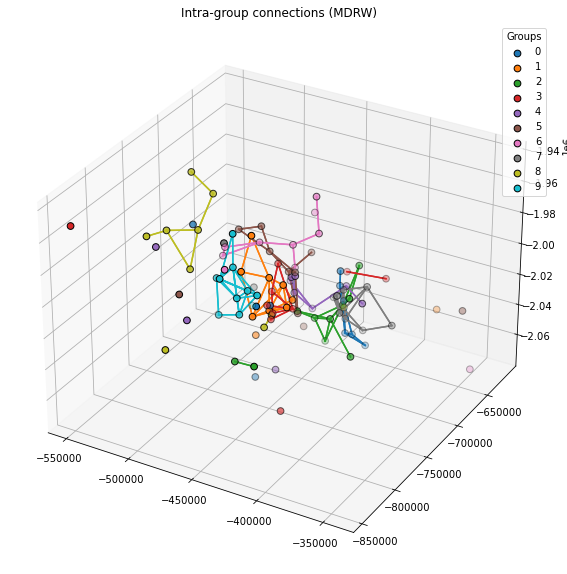

In [152]:
plot_groups(mdrw_swarms, title='Intra-group connections (MDRW)')

In [119]:
for gid, sw in mdrw_swarms.items():
    isl = 0
    for node in sw.nodes:
            for n in node.neighbors:
                if n.group==node.group:
                    isl+=1
    print('Number of ISLs in group', gid,':', int(isl/2))

Number of ISLs in group 0 : 8
Number of ISLs in group 1 : 17
Number of ISLs in group 2 : 14
Number of ISLs in group 3 : 11
Number of ISLs in group 4 : 9
Number of ISLs in group 5 : 9
Number of ISLs in group 6 : 7
Number of ISLs in group 7 : 14
Number of ISLs in group 8 : 7
Number of ISLs in group 9 : 21


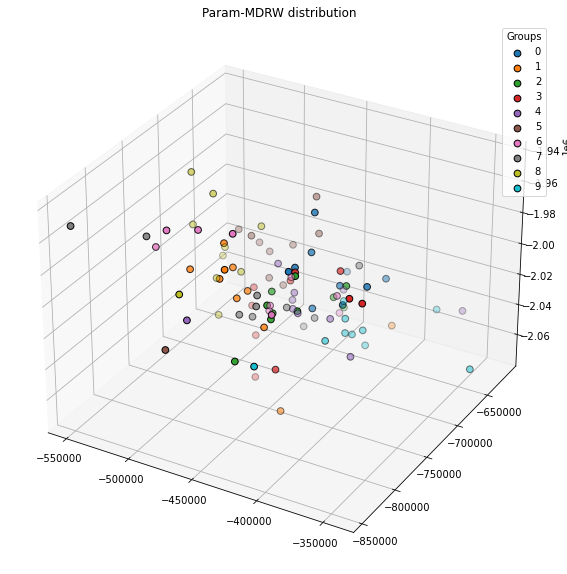

In [153]:
plot_groups(param_mdrw_swarms, title='Param-MDRW distribution', show_edges=False)

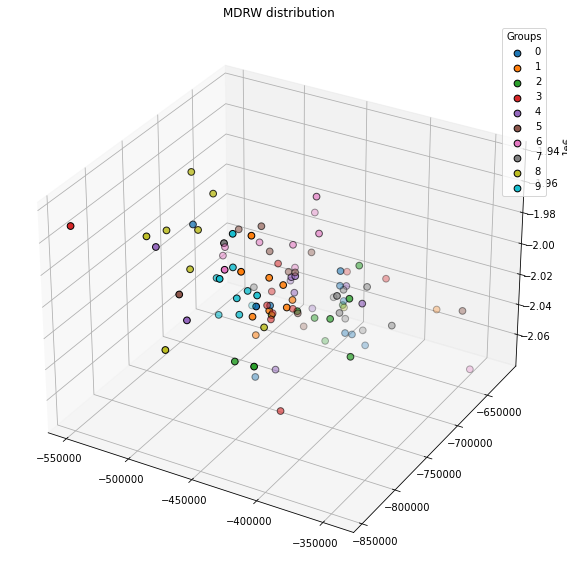

In [154]:
plot_groups(mdrw_swarms, title='MDRW distribution', show_edges=False)

In [156]:
for gid, sw in param_mdrw_swarms.items():
    print('Group:', gid, '\tConnected components:', len(sw.connected_components()))

Group: 0 	Connected components: 1
Group: 1 	Connected components: 3
Group: 2 	Connected components: 3
Group: 3 	Connected components: 2
Group: 4 	Connected components: 4
Group: 5 	Connected components: 2
Group: 6 	Connected components: 4
Group: 7 	Connected components: 5
Group: 8 	Connected components: 3
Group: 9 	Connected components: 4


In [157]:
for gid, sw in mdrw_swarms.items():
    print('Group:', gid, '\tConnected components:', len(sw.connected_components()))

Group: 0 	Connected components: 5
Group: 1 	Connected components: 3
Group: 2 	Connected components: 2
Group: 3 	Connected components: 4
Group: 4 	Connected components: 4
Group: 5 	Connected components: 4
Group: 6 	Connected components: 4
Group: 7 	Connected components: 3
Group: 8 	Connected components: 4
Group: 9 	Connected components: 2
